# Code to Display Daily Maximum Winds expected over Fire Danger Zones

### Objective: 
This Python 3 Jupyter notebook calculates the daily maximum wind speed (mph) expected at Fire Danger Climate Zones in California (Zones 1-9, does NOT include the Central Valley). 

The code should run in about 10 minutes.

The result is a map of maximum daily wind speed by zone.

### Inputs:
WRF_FILE : the WRF model dataset with hourly weather forecasts for a random day, in NetCDF format 

SHAPE_PATH : Path to folder with the FDCZ (Fire Danger Climate Zone) polygons, as shape files 

MASK_FILE : land/sea mask file, in NetCDF format

### Outputs:
OUTPUT_FILE : a map displaying each climate zone color coded by the maximum daily wind speed, in miles per hour.


#### Created by Edwin Campos, on 2020 Apr.27: Last modification on 2020 Apr.27 by ecampos.phd@gmail.com


## Environment Setup

In [1]:
# Global Input Variables
WRF_FILE = 'wrf_daily_ts_2017-10-08.nc'
MASK_FILE='invariant_d01.nc'
SHAPE_PATH='./fdcz_pl'
OUTPUT_FILE = 'fdcz_max_winds_mph.png'

In [2]:
# Dependencies
import numpy as np
import pandas as pd
from netCDF4 import Dataset
import geopandas
import matplotlib.pyplot as plt

## Read NetCDF files

References:

    https://anaconda.org/anaconda/netcdf4
    http://atmos.colostate.edu/~btrabing/Read_WRF.html
    https://stackoverflow.com/questions/35297771/wrf-netcdf-file-subset-smaller-array-out-of-dataset-based-on-coordinate-bounda

In [3]:
# Input WRF dataset
wrf_data = Dataset(WRF_FILE, "r")
mask_data= Dataset(MASK_FILE, "r")

In [4]:
# Get the horizontal grid
lats = mask_data.variables['XLAT'][:]    # degree_north
longs = mask_data.variables['XLONG'][:]  # degree_east

In [5]:
# Get the Wind speed
u10 = wrf_data.variables['U10'][:]   # U component of wind at 10m, in m/s
v10 = wrf_data.variables['V10'][:]   # V component of wind at 10m, in m/s

## Read Shape files with GeoPandas

Using only Climate zones 1-9 (don’t include the Central Valley). 

References:

    https://pypi.org/project/geopandas/
    https://geopandas.org/projections.html
            

In [6]:
# Ingest dataset
geodf = geopandas.read_file(SHAPE_PATH)

In [7]:
# Remove  Central Valley zone
geodf = geodf.drop(geodf[geodf['FDCZ']=='CV'].index).reset_index()

In [8]:
# Convert geometries into Latitude and Longitude
geodf_geo = geodf.to_crs(epsg=4326)

## Expand Multipolygons into one Polygon per row

In [9]:
# Use reset_index to avoid complex indices that would complicate FOR loops
geodf_geo_exploded = geodf_geo.explode().reset_index()

In [10]:
# Create a new column that combines information on the climate zone and the shape geometry 
# (to identify geometries comming from a multipolygon)
geodf_geo_exploded["polygon"] = geodf_geo_exploded.apply(lambda x: f'{x["FDCZ"]}_{x["level_1"]}', axis=1)

## Calculate the maximum daily wind speeds

Using the Point in Polygon (Ray Casting) algorithm, to associate WRF grid points to particular Fire Danger Climate Zones.

References:
    
    https://en.wikipedia.org/wiki/Point_in_polygon#Ray_casting_algorithm
    
    https://automating-gis-processes.github.io/CSC18/lessons/L4/point-in-polygon.html

In [11]:
max_winds_df = pd.DataFrame(columns=['polygon'])
max_winds_df['polygon'] = geodf_geo_exploded['polygon']
max_winds_df['speed'] = np.nan

In [12]:
# This part should run in less than 9 minutes
for wrf_x_indx in range(lats.shape[1]):              # Loop over WRF grid points
    for wrf_y_indx in range(lats.shape[2]):
        
        # Create point shapes from WRF grid point
        df_pnt = pd.DataFrame(
            {'Latitude': [ lats[ 0,wrf_x_indx,wrf_y_indx] ],
             'Longitude':[ longs[0,wrf_x_indx,wrf_y_indx] ] })
        geodf_geo_pnt = geopandas.GeoDataFrame(
            df_pnt, geometry=geopandas.points_from_xy(df_pnt.Longitude, df_pnt.Latitude))
        
        # Is this point in the Fire Danger Climatic Zone?
        for polygon_indx in range(geodf_geo_exploded.shape[0]):  # Loop over the Fire Danger Climate Zones 
            which_polygon = str( geodf_geo_exploded['polygon'].iloc[polygon_indx] )
            within = geodf_geo_pnt.within(geodf_geo_exploded.loc[polygon_indx,'geometry'])
            if within[0]:   # Calculate daily maximum wind speed only if inside a Fire Danger Climate Zone
                u10_time = u10[:,wrf_x_indx,wrf_y_indx]
                v10_time = v10[:,wrf_x_indx,wrf_y_indx]
                speed_time = (u10_time**2 + v10_time**2)**0.5
                current_max_wind = max_winds_df['speed'].loc[ max_winds_df['polygon'] == which_polygon ]
                current_max_wind = current_max_wind.item()
                new_max_wind = max( max(speed_time),current_max_wind )
                max_winds_df['speed'].loc[ max_winds_df['polygon'] == which_polygon ] = new_max_wind

/Applications/anaconda/envs/netcdf/lib/python3.7/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [13]:
factor_from_mps_to_mph = 2.23694  # 1 m/s = 2.23694 miles per hour
geodf_geo_exploded['MaxWind'] = max_winds_df["speed"]    # In meters/second
geodf_geo_exploded['MaxWind_mph'] = max_winds_df["speed"] * factor_from_mps_to_mph  # In miles/hour

## Results
    - Dataframe with desired values
    - Map displaying each climate zone color coded by the maximum daily wind speed. 

In [14]:
print(geodf_geo_exploded)

   level_0  level_1  index  OBJECTID FDCZ    Shape_Leng    Shape_Area  \
0        0        0      0         1    2  1.390085e+06  1.766655e+10   
1        0        1      0         1    2  1.390085e+06  1.766655e+10   
2        1        0      1         2    7  7.294358e+05  1.543029e+10   
3        2        0      2         3    4  9.584138e+05  9.903732e+09   
4        3        0      3         4    8  1.449745e+06  3.008260e+10   
5        4        0      4         5    1  7.236206e+05  1.336352e+10   
6        5        0      6         7    6  1.499360e+06  3.551770e+10   
7        6        0      7         8    5  1.025812e+06  2.345961e+10   
8        7        0      8        10    3  1.108385e+06  1.449150e+10   
9        7        1      8        10    3  1.108385e+06  1.449150e+10   

                                            geometry polygon    MaxWind  \
0  POLYGON ((-122.77477 38.82187, -122.77270 38.8...     2_0        NaN   
1  POLYGON ((-122.77477 38.82187, -122.77277 3

/Applications/anaconda/envs/netcdf/lib/python3.7/site-packages/matplotlib/colors.py:527: RuntimeWarning: invalid value encountered in less
  xa[xa < 0] = -1


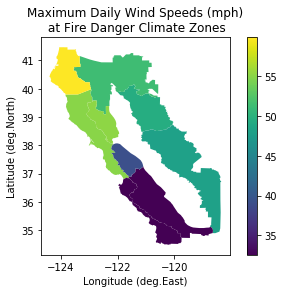

In [15]:
# Visualize exploded geometries in Lat Lon coordinates map
ax = geodf_geo_exploded.plot(column='MaxWind_mph',legend=True)
ax.set_title("Maximum Daily Wind Speeds (mph)\n at Fire Danger Climate Zones")
ax.set_xlabel("Longitude (deg.East)")
ax.set_ylabel("Latitude (deg.North)")

# Save figure as PNG file
plt.savefig(OUTPUT_FILE)